In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from time import time
from sklearn.metrics import roc_auc_score
import tensorflow as tf

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import BiMent

## Get Data

In [3]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/reality-mining/txt/interim/appsByWeek-clean.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [4]:
def convert_to_dict(df):
    data_dict = {}
    
    unique = list(df.iloc[:, 2].unique())
    
    date_list = [df.iloc[0, 1]]
    pid_date_list = [(df.iloc[0,0], df.iloc[0, 1])]
    
    data_dict[int(df.iloc[0,0])] = {}
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]] = np.zeros((len(unique),))
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]][unique.index(df.iloc[0, 2])] = 1
        
    for r in range(1, len(df.index)):
        pid = int(df.iloc[r, 0])
        if pid not in data_dict.keys():
            data_dict[pid] = {}        
        
        if (df.iloc[r, 0], df.iloc[r, 1]) in pid_date_list:
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1 #df.iloc[r, 3]
        else:
            date_list.append(df.iloc[r, 1])
            pid_date_list.append((df.iloc[r, 0], df.iloc[r, 1]))
            
            data_dict[pid][df.iloc[r, 1]] = np.zeros((len(unique),))
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1
                        
    return data_dict, unique

In [5]:
data_dict, unique = convert_to_dict(df)

In [6]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
#             print pid, date
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [7]:
x_train, y_train = dict_to_np_array(data_dict)

## Weighted Correlation

### Generate Test Data

In [8]:
N_SINGLETONS = 65
N_PAIRS = 5

In [9]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)

remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)

pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)

In [10]:
vec_list = []
labels = []
GT_POS_PAIRS = []

pid_list = data_dict.keys()

for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]

    vec_list.append(app_vec1)
    vec_list.append(app_vec2)

    labels.append(p + 1)
    labels.append(p + 1)
    GT_POS_PAIRS.append((2* p, 2* p + 1))

for s in singletons:
    pid = pid_list[s]
    w = np.random.choice(data_dict[pid].keys(), 1)
    app_vec = data_dict[pid][w[0]]
    vec_list.append(app_vec)
    labels.append(0)
    
adj_mx = np.array(vec_list)

In [11]:
print adj_mx

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


### Baseline

In [12]:
phi = adj_mx.sum(axis=0) / adj_mx.shape[0]
print phi[:20]

[0.94666667 0.90666667 0.21333333 0.88       0.53333333 0.04
 0.98666667 0.90666667 0.72       0.93333333 0.14666667 0.36
 0.33333333 0.2        0.02666667 0.28       0.21333333 0.16
 0.05333333 0.85333333]


In [13]:
# Ensure all p_i's are non-zero
adj_mx_nonzero = adj_mx.copy()
adj_mx_nonzero = adj_mx_nonzero[:, np.where(np.logical_and(phi > 0, phi < 1))[0]]

phi = adj_mx_nonzero.sum(axis=0) / adj_mx_nonzero.shape[0]
print phi

[0.94666667 0.90666667 0.21333333 0.88       0.53333333 0.04
 0.98666667 0.90666667 0.72       0.93333333 0.14666667 0.36
 0.33333333 0.2        0.02666667 0.28       0.21333333 0.16
 0.05333333 0.85333333 0.08       0.10666667 0.44       0.26666667
 0.08       0.05333333 0.01333333 0.10666667 0.42666667 0.01333333
 0.04       0.09333333 0.05333333 0.06666667 0.16       0.08
 0.14666667 0.06666667 0.01333333 0.02666667 0.14666667 0.05333333
 0.04       0.01333333 0.06666667 0.01333333 0.01333333 0.10666667
 0.05333333 0.10666667 0.05333333 0.02666667 0.06666667 0.12
 0.08       0.01333333 0.01333333 0.02666667 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.02666667
 0.01333333 0.01333333 0.01333333]


In [14]:
# %%timeit
start = time()

WC_arr = []
WC_idx = []
for i in np.arange(adj_mx_nonzero.shape[0]):
    for j in np.arange(i + 1, adj_mx_nonzero.shape[0]):
        X = adj_mx_nonzero[i]
        Y = adj_mx_nonzero[j]
        
        WC = (1.0/ phi.shape[0])* (X- phi)* (Y- phi)/ (phi*(1-phi))
        WC_arr.append(WC.sum())
        
        if (i, j) in GT_POS_PAIRS:
            WC_idx.append(True)
        else:
            WC_idx.append(False)
            
print 'time elapsed: %f sec' % (time() - start)
WC_arr = np.array(WC_arr)
WC_idx = np.array(WC_idx)

time elapsed: 0.058976 sec


In [15]:
WC_arr[WC_idx]

array([ 0.08230412, -0.35925411,  0.16966359,  0.03460939,  0.08745092])

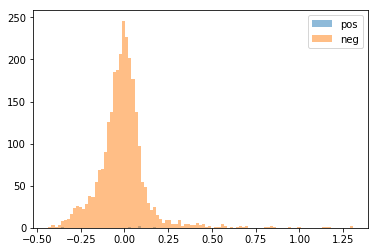

In [16]:
bins = np.linspace(WC_arr.min(), WC_arr.max(), 100)

plt.hist(WC_arr[WC_idx], bins, alpha=0.5, label='pos')
plt.hist(WC_arr[WC_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [17]:
print roc_auc_score(y_true=WC_idx, y_score=WC_arr)

0.6855956678700361


### Estimate Phi using ERGM

In [22]:
fs = adj_mx.sum(axis=1)
gs = adj_mx.sum(axis=0)
X, Y, X_bak, Y_bak = BiMent.solver(fs, gs, tolerance=1e-5, max_iter=10000)

counter=0, change=2.588970
counter=500, change=0.096531
counter=1000, change=0.001060
counter=1500, change=0.000012
Solver done in 4.0 seconds.
Solver converged in 1517 iterations.


In [24]:
X_bak, Y_bak

(array([0.34960295, 0.28603878, 0.09534626, 0.98524468, 0.34960295,
        0.34960295, 0.38138504, 0.31782086, 0.28603878, 0.85811633,
        0.47673129, 0.44494921, 0.25425669, 0.28603878, 0.28603878,
        0.28603878, 0.15891043, 0.28603878, 0.31782086, 0.54029547,
        0.41316712, 0.66742381, 0.34960295, 0.31782086, 0.41316712,
        0.41316712, 0.66742381, 0.09534626, 0.47673129, 0.63564173,
        0.57207755, 0.28603878, 0.09534626, 0.44494921, 0.28603878,
        0.28603878, 0.54029547, 0.34960295, 0.44494921, 0.41316712,
        0.31782086, 0.25425669, 0.44494921, 0.31782086, 0.38138504,
        0.38138504, 0.15891043, 0.50851338, 0.19069252, 0.34960295,
        0.28603878, 0.44494921, 0.73098799, 0.88989842, 0.47673129,
        0.95346259, 0.34960295, 0.63564173, 0.25425669, 0.38138504,
        0.54029547, 0.38138504, 0.41316712, 1.04880885, 0.41316712,
        0.34960295, 0.79455216, 0.28603878, 0.41316712, 0.28603878,
        0.66742381, 0.03178209, 0.41316712, 0.38

In [27]:
N = np.sum(fs)
X = tf.Variable(fs / np.sqrt(N))
Y = tf.Variable(gs / np.sqrt(N))
fs_const = tf.constant(fs)
gs_const = tf.constant(gs)

In [28]:
XYt = tf.matmul(tf.reshape(X, (-1, 1)), tf.reshape(Y, (1,-1)))
f_func = tf.reduce_sum(XYt / (1+ XYt), axis=1) - fs_const
print f_func
# tf.matmul(tf.reshape(X, (-1, 1)), tf.reshape(Y, (1,-1)))

Tensor("sub_2:0", shape=(75,), dtype=float64)


In [29]:
YXt = tf.matmul(tf.reshape(Y, (-1, 1)), tf.reshape(X, (1,-1)))
g_func = tf.reduce_sum(YXt / (1+ YXt), axis=1) - gs_const
print g_func

Tensor("sub_3:0", shape=(206,), dtype=float64)


In [30]:
loss = tf.reduce_sum(tf.concat([f_func, g_func], axis=0))
print loss

Tensor("Sum_5:0", shape=(), dtype=float64)


In [31]:
opt = tf.train.AdamOptimizer(2.0).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

print sess.run(X)
print sess.run(Y)

[0.34960295 0.28603878 0.09534626 0.98524468 0.34960295 0.34960295
 0.38138504 0.31782086 0.28603878 0.85811633 0.47673129 0.44494921
 0.25425669 0.28603878 0.28603878 0.28603878 0.15891043 0.28603878
 0.31782086 0.54029547 0.41316712 0.66742381 0.34960295 0.31782086
 0.41316712 0.41316712 0.66742381 0.09534626 0.47673129 0.63564173
 0.57207755 0.28603878 0.09534626 0.44494921 0.28603878 0.28603878
 0.54029547 0.34960295 0.44494921 0.41316712 0.31782086 0.25425669
 0.44494921 0.31782086 0.38138504 0.38138504 0.15891043 0.50851338
 0.19069252 0.34960295 0.28603878 0.44494921 0.73098799 0.88989842
 0.47673129 0.95346259 0.34960295 0.63564173 0.25425669 0.38138504
 0.54029547 0.38138504 0.41316712 1.04880885 0.41316712 0.34960295
 0.79455216 0.28603878 0.41316712 0.28603878 0.66742381 0.03178209
 0.41316712 0.38138504 0.57207755]
[2.25652813 2.16118187 0.50851338 2.0976177  1.27128345 0.09534626
 2.35187439 2.16118187 1.71623266 2.22474604 0.34960295 0.85811633
 0.79455216 0.47673129 0.06

In [32]:
iterations = 10000
for i in range(iterations):
    if i % 1000 == 0 or i + 1 == iterations:
        print 'i=%d, loss=%f' % (i, sess.run(loss))
    sess.run(opt)

i=0, loss=-719.003987
i=1000, loss=28919.440733
i=2000, loss=28919.094971
i=3000, loss=28912.170696
i=4000, loss=28917.149641
i=5000, loss=28916.545625
i=6000, loss=28917.985242
i=7000, loss=28916.907918
i=8000, loss=28913.440444
i=9000, loss=28924.974832
i=9999, loss=28922.381943


In [33]:
sess.run(X)

array([ 23.15627534, -91.69177223,  35.13176131,  36.29898602,
        23.15627534,  23.15627534,  18.79752163,  61.3545261 ,
       -91.69177223,  65.46050452,  63.36115972,  50.30754974,
        62.58587789, -91.69177223, -91.69177223, -91.69177223,
        69.96097748, -91.69177223,  61.3545261 ,  92.40996343,
       110.79311455, -11.04621249,  23.15627534,  61.3545261 ,
       110.79311455, 110.79311455, -11.04621249,  35.13176131,
        63.36115972, -54.99567251, -63.4915764 , -91.69177223,
        35.13176131,  50.30754974, -91.69177223, -91.69177223,
        92.40996343,  23.15627534,  50.30754974, 110.79311455,
        61.3545261 ,  62.58587789,  50.30754974,  61.3545261 ,
        18.79752163,  18.79752163,  69.96097748, 109.06487684,
        21.15171543,  23.15627534, -91.69177223,  50.30754974,
        92.89707646,  58.19412663,  63.36115972,  23.04279156,
        23.15627534, -54.99567251,  62.58587789,  18.79752163,
        92.40996343,  18.79752163, 110.79311455,  22.05

In [19]:
fs / np.sqrt(N)

array([0.23786968, 0.44175798, 0.50972075, 0.54370213, 0.33981383,
       0.4077766 , 0.54370213, 0.37379522, 0.37379522, 0.2038883 ,
       0.16990692, 0.13592553, 0.44175798, 0.23786968, 0.44175798,
       0.4077766 , 0.6116649 , 0.33981383, 0.33981383, 0.37379522,
       0.50972075, 0.10194415, 0.06796277, 0.33981383, 0.47573937,
       0.2038883 , 0.4077766 , 0.4077766 , 0.06796277, 0.30583245,
       0.23786968, 0.23786968, 0.4077766 , 0.37379522, 0.64564628,
       0.16990692, 0.27185107, 0.10194415, 0.33981383, 0.37379522,
       0.50972075, 0.57768352, 0.47573937, 0.33981383, 0.37379522,
       0.30583245, 0.47573937, 0.33981383, 0.37379522, 0.16990692,
       0.44175798, 0.44175798, 0.50972075, 1.0194415 , 0.33981383,
       0.50972075, 0.23786968, 0.33981383, 0.6116649 , 0.33981383,
       0.4077766 , 0.37379522, 0.33981383, 0.33981383, 0.30583245,
       0.50972075, 0.33981383, 0.91749735, 1.12138565, 0.4077766 ,
       0.33981383, 0.50972075, 0.27185107, 0.57768352, 0.40777

In [20]:
phi_ia = X[:, None] * Y / (1 + X[:, None] * Y)
print phi_ia

[[3.91176060e-01 6.24347339e-01 1.58163586e-03 ... 0.00000000e+00
  0.00000000e+00 4.18924386e-05]
 [9.99109326e-01 9.99655494e-01 7.34446348e-01 ... 0.00000000e+00
  0.00000000e+00 6.81569958e-02]
 [9.84905560e-01 9.94110238e-01 1.38581476e-01 ... 0.00000000e+00
  0.00000000e+00 4.23649867e-03]
 ...
 [9.70464809e-01 9.88371573e-01 7.49415353e-02 ... 0.00000000e+00
  0.00000000e+00 2.13788251e-03]
 [9.88510811e-01 9.95526971e-01 1.75007101e-01 ... 0.00000000e+00
  0.00000000e+00 5.57873532e-03]
 [9.88510811e-01 9.95526971e-01 1.75007101e-01 ... 0.00000000e+00
  0.00000000e+00 5.57873532e-03]]


In [21]:
phi_ia.shape

(75, 206)

In [22]:
X[0]*Y[2] / (1+X[0]*Y[2])

0.0015816358595229865

In [23]:
# %%timeit
start = time()

WC_arr = []
WC_idx = []
for i in np.arange(adj_mx.shape[0]):
    for j in np.arange(i + 1, adj_mx.shape[0]):
        X = adj_mx[i]
        Y = adj_mx[j]
        E_X = phi_ia[i]
        E_Y = phi_ia[j]
        
        WC = (1.0/ phi_ia.shape[1])* (X- E_X)* (Y- E_Y)/ (np.sqrt(E_X*E_Y*(1-E_X)*(1-E_Y)) + 1e-6)
#         print WC
        WC_arr.append(WC.sum())
        
        if (i, j) in GT_POS_PAIRS:
            WC_idx.append(True)
        else:
            WC_idx.append(False)
            
print 'time elapsed: %f sec' % (time() - start)
WC_arr = np.array(WC_arr)
WC_idx = np.array(WC_idx)

time elapsed: 0.064398 sec


In [24]:
WC_arr[WC_idx]

array([ 0.00117127,  0.35071993, -0.02112845,  0.01081529,  0.01734086])

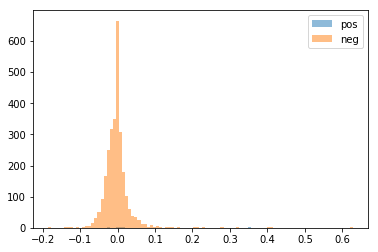

In [25]:
bins = np.linspace(WC_arr.min(), WC_arr.max(), 100)

plt.hist(WC_arr[WC_idx], bins, alpha=0.5, label='pos')
plt.hist(WC_arr[WC_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [26]:
print roc_auc_score(y_true=WC_idx, y_score=WC_arr)

0.7088447653429604
